In [1]:
import numpy as np
from matplotlib import pyplot as plt
import decimal
from scipy import signal

In [2]:
%matplotlib inline

In [3]:
def drange(x, y, jump):
    x = decimal.Decimal(x)
    while x < y:
        yield float(x)
        x += decimal.Decimal(jump)

In [4]:
def data_creator(func, interval, step, plot = False, noise_var = None):
    patterns = list(drange(interval[0],interval[1], str(step)))
    f = np.vectorize(func)
    output = f(patterns)
    if noise_var:
        noise = np.random.normal(loc = 0, scale = noise_var, size = np.shape(output))
        output =np.add(output, noise)
    if plot:
        plt.plot(patterns, output)
        plt.show()
    patterns = np.reshape(patterns, (len(patterns),1))
    output = np.reshape(output, (len(output),1))
    patterns = np.array(patterns)
    output = np.array(output)
    return patterns, output

In [5]:
sin_training_patterns, sin_training_response = data_creator(lambda x: np.sin(2*x),[0,2*np.pi], 0.1)

In [6]:
sin_testing_patterns, sin_testing_response = data_creator(lambda x: np.sin(2*x),[0.05,2*np.pi], 0.1)

In [7]:
square_training_patterns, square_training_response = data_creator(lambda x: signal.square(2*x), [0,2*np.pi], 0.1)

In [8]:
square_testing_patterns, square_testing_response = data_creator(lambda x: signal.square(2*x), [0.05,2*np.pi], 0.1)

In [9]:
#TODO everything

In [10]:
class RBFNet():
    def __init__(self, mu_list, sigma):
        self.weights = None
        self.mu = mu_list
        self.train_phi = None
        self.sigma = sigma
        self.trained = False
        
    def RBF(self, x, mu, sigma):
        return np.exp((-(np.linalg.norm(x-mu))**2)/(2*sigma**2))
    
    def initiate_nodes(mu_list, sigma):
        self.mu = mu_list
    
    def calculate_phi(self, data):
        N = len(data)
        n = len(self.mu)
        phi = np.zeros((N,n))
        for i in range(N):
            for j in range(n):
                phi[i,j] = self.RBF(data[i,:], self.mu[j,:], self.sigma)
        return phi
    
    def batch_train(self, data, response):
        self.train_phi = self.calculate_phi(data)
        phi_transpose = np.transpose(self.train_phi)
        self.weights = np.linalg.inv(np.dot(phi_transpose,self.train_phi)).dot(phi_transpose).dot(response)
        self.trained = True
    
    def data_shuffler(self, data, response):
        data_dim = np.shape(data)[1]
        response_dim = np.shape(response)[1]
        shuffler = np.hstack((data, response))
        np.random.shuffle(shuffler)
        return shuffler[:,0:data_dim], shuffler[:,data_dim:data_dim+response_dim] #Will break down with multidimensional data, i think?

    def sequential_train(self, data, response, epochs, eta):
        data, response = self.data_shuffler(data, response)
        self.train_phi = self.calculate_phi(data)
        self.weights = np.random.randn(len(self.mu),1)
        
        for epoch in range(epochs):
            for data_index in range(len(data)):
                inner = response[data_index] - np.dot(self.train_phi[data_index,:],self.weights)
                self.weights = np.add(self.weights, np.reshape(eta*inner*np.transpose(self.train_phi[data_index,:]),np.shape(self.weights)))
                
        
    def predict(self,data):
        phi = self.calculate_phi(data)
        return phi.dot(self.weights)
    
    def calculate_error(self, data, response):
        predictions = self.predict(data)
        return np.mean(np.abs(response-predictions))
    
    def report(self, train_data, train_response, test_data, test_response, batch_train = True, **kwargs):
            if batch_train:
                self.batch_train(train_data, train_response)
            else:
                self.sequential_train(train_data, train_response, kwargs['epochs'], kwargs['eta'])
            train_error = self.calculate_error(train_data, train_response)
            test_error = self.calculate_error(test_data, test_response)
            if np.shape(self.mu)[1] <= 1:
                plt.plot(train_data, network.predict(train_data))
                plt.title("Training")
                plt.figtext(.02, .02, "Training error is {}".format(train_error))
                plt.show()

                plt.plot(test_data, network.predict(test_data))
                plt.title("Testing")
                plt.figtext(.02, .02, "Testing error is {}".format(test_error))
                plt.show()
            else:
                print("Training error is {}".format(train_error))
                print("Testing error is {}".format(test_error))



In [11]:
def even_rbf_center(count):
    mu_list = []
    for i in range(count):
        mu_list.append(i*2*np.pi/(count))
    mu_list = np.reshape(np.array(mu_list), (len(mu_list),1))
    return mu_list

In [12]:
mu_list = even_rbf_center(50)
sigma = 0.1
network = RBFNet(mu_list, sigma)

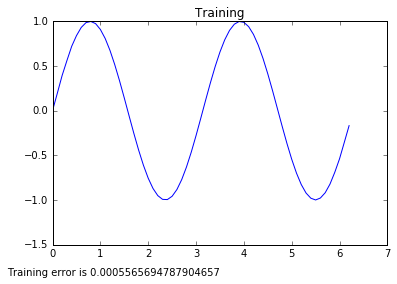

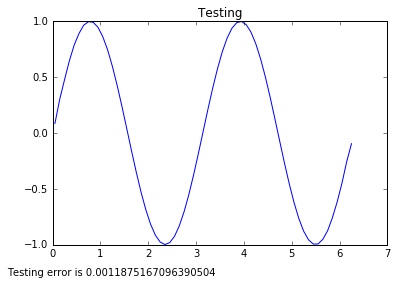

In [13]:
network.report(sin_training_patterns, sin_training_response, sin_testing_patterns, sin_testing_response)

In [32]:
mu_list = even_rbf_center(20)
sigma = 0.6
mu_list = np.reshape(np.array(mu_list), (len(mu_list),1))
network = RBFNet(mu_list, sigma)

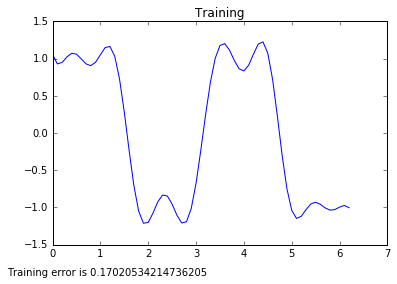

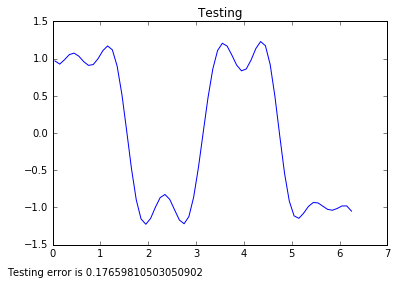

In [17]:
network.report(square_training_patterns, square_training_response, square_testing_patterns, square_testing_response)

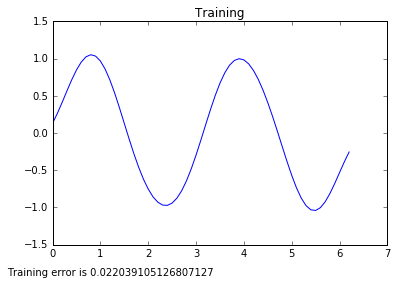

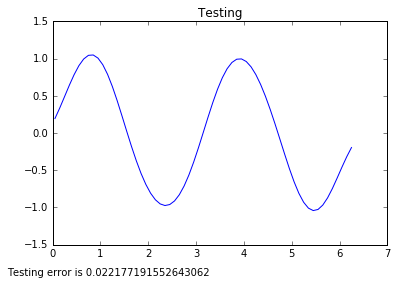

In [18]:
network.report(sin_training_patterns, sin_training_response, sin_testing_patterns, sin_testing_response,
                batch_train = False, eta=0.3, epochs = 100)

In [36]:
sin_training_patterns_g, sin_training_response_g = data_creator(lambda x: np.sin(2*x),[0,2*np.pi], 0.1,noise_var = 0.3)

In [37]:
sin_testing_patterns_g, sin_testing_response_g = data_creator(lambda x: np.sin(2*x),[0.05,2*np.pi], 0.1, noise_var=0.3)

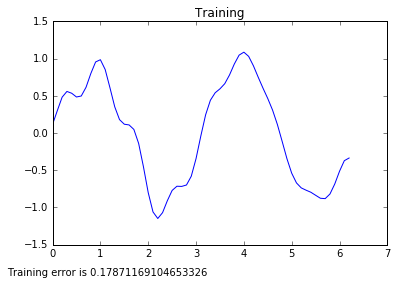

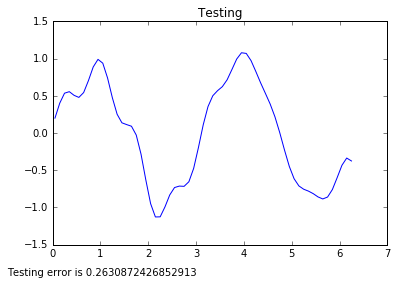

In [38]:
network.report(sin_training_patterns_g, sin_training_response_g, sin_testing_patterns_g, sin_testing_response_g,
                batch_train = True)

### Competitive learning

In [31]:
network.report(sin_training_patterns_g, sin_training_response_g, sin_testing_patterns_g, sin_testing_response_g,
                batch_train = False, eta=0.01, epochs = 100)

Training error is 0.6116493098703487
Testing error is 0.6024979957527022


In [23]:
def competetive_RBF_centers(data, nodecount, eta, iterations):
    np.random.shuffle(data)
    RBF = data[0:nodecount].copy()
    for j in range(iterations):
        randvec = data[np.random.randint(0,len(data)),:] #Breaks down in multidimensional case
        distances = np.empty((0,0))
        for center in RBF:
            distances = np.append(distances,(np.linalg.norm(center-randvec)))
        
        RBF[distances.argmin()] += eta * (randvec-RBF[distances.argmin()])
    return RBF


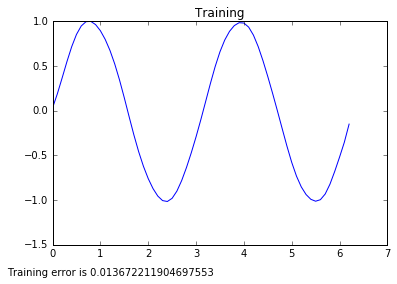

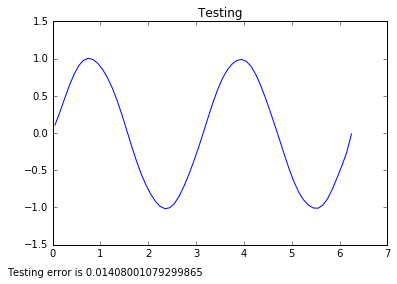

In [24]:
mu_list = competetive_RBF_centers(sin_training_patterns_g, 20, 1, 100)
sigma = 0.6
network = RBFNet(mu_list, sigma)
network.report(sin_training_patterns, sin_training_response, sin_testing_patterns, sin_testing_response)

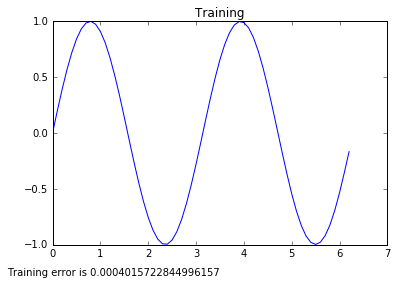

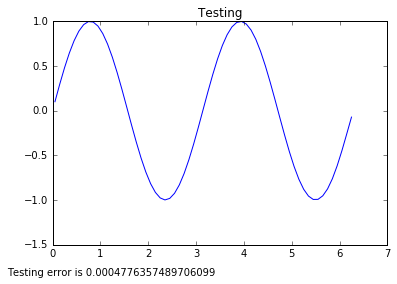

In [25]:
mu_list = even_rbf_center(20)
sigma = 0.6
network = RBFNet(mu_list, sigma)
network.report(sin_training_patterns, sin_training_response, sin_testing_patterns, sin_testing_response)

In [26]:
cd data

/Users/alexander/projects/DD2437/Lab2/data


In [27]:
ballistic_data = np.loadtxt(open("ballist.dat", "rb"), delimiter=" ", skiprows=0)
balltest_data = np.loadtxt(open("balltest.dat", "rb"), delimiter=" ", skiprows=0)

In [28]:
train_ballistic = ballistic_data[:,0:2]
train_ballistic_response = ballistic_data[:,2:4]
test_ballistic = balltest_data[:,0:2]
test_ballistic_response = balltest_data[:,2:4]

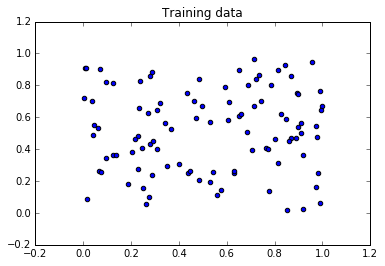

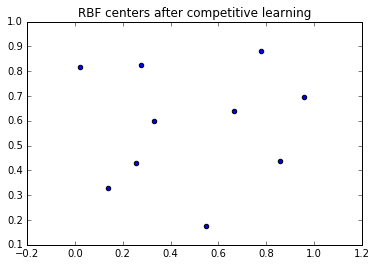

In [29]:
sigma = 0.3
eta = 0.2
nodecount = 10
iterations = 100

mu_list = competetive_RBF_centers(train_ballistic, nodecount, eta, iterations)
plt.scatter(train_ballistic[:,0], train_ballistic[:,1])
plt.title('Training data')
plt.show()

plt.scatter(mu_list[:,0], mu_list[:,1])
plt.title('RBF centers after competitive learning')
plt.show()
network = RBFNet(mu_list, sigma)


In [30]:
network.report(train_ballistic, train_ballistic_response, test_ballistic, test_ballistic_response)

Training error is 0.15394594139331239
Testing error is 0.20254162452114777
